In [1]:
#Edit:2017-11-21
#@sima
#%%
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
class Timer(object):
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

    def tic(self):
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff
        
        
from keras.layers import Input,Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers import Flatten,BatchNormalization,Permute,TimeDistributed,Dense,Bidirectional,GRU
from keras.models import Model


import numpy as np
from PIL import Image
import keras.backend  as K

from imp import reload 
import densenet
reload(densenet)

import os
from keras.layers import Lambda
from keras.optimizers import SGD

import tensorflow as tf  
import keras.backend.tensorflow_backend as K  
from matplotlib import pyplot as plt

def get_session(gpu_fraction=0.8):  
    '''''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''  
  
    num_threads = os.environ.get('OMP_NUM_THREADS')  
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)  
  
    if num_threads:  
        return tf.Session(config=tf.ConfigProto(  
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))  
    else:  
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  
  
K.set_session(get_session()) 


char=''
with open('char_jehjxx.txt',encoding='utf-8') as f:
      for ch in f.readlines():
            ch = ch.strip('\r\n')
            char=char+ch
            
#caffe_ocr中把0作为blank，但是tf 的CTC  the last class is reserved to the blank label.
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/util/ctc/ctc_loss_calculator.h
char =char[1:]+'卍'
nclass = len(char)
print('nclass:',len(char))
id_to_char = {i:j for i,j in enumerate(char)}


modelPath =r'weights_densenet-20190110_plug1142_02-0.57.h5'
input = Input(shape=(32,None,1),name='the_input')
y_pred= densenet.dense_cnn(input,nclass)
basemodel = Model(inputs=input,outputs=y_pred)
basemodel.load_weights(modelPath)
   
t = Timer()
def predict(img_path):
    
    img = Image.open(img_path)
    im = img.convert('L')
    scale = im.size[1]*1.0 / 32
    w = im.size[0] / scale
    w = int(w)
    print('w:',w)
    
    im = im.resize((w,32),Image.ANTIALIAS)
    img = np.array(im).astype(np.float32)/255.0-0.5
    X  = img.reshape((32,w,1))
    X = np.array([X])
    
    
    t.tic()
    y_pred = basemodel.predict(X)
    t.toc()
    print("times,",t.diff)
    argmax = np.argmax(y_pred, axis=2)[0]
    
    y_pred = y_pred[:,:,:]
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :]
    out = u''.join([id_to_char[x] for x in out[0]])


    return out,im

 

Using TensorFlow backend.
/root/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


nclass: 15


w: 139
times, 0.014849662780761719
预测m1: ￥2,.00.00


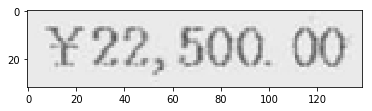

In [11]:
testimage = r'small_bitao.png'
#testimage = r'E:\deeplearn\OCR\Sample\samples\000000001.jpg'
b,img= predict(testimage)
print('预测m1:',b)

plt.imshow(img)